In [1]:
#import neccessary libraries
import numpy as np
import evaluation as ev
import csv
import pandas as pd
import scipy.stats

In [2]:
#read noise distribution of desired particle to do energy resolution on for a given energy level
root_file = 'Gamma-E25-n1000-part9'
df = pd.read_csv('cluster-noise-distribution_'+root_file+'.csv')
df

,noise,n_events,n_clusters_mean
0,0.05,1000,7.11
1,0.10,1000,3.46
2,0.15,1000,2.74
3,0.20,1000,2.41
4,0.25,1000,2.36
5,0.30,1000,2.44
6,0.35,1000,2.62
7,0.40,1000,2.93
8,0.45,1000,3.40
9,0.50,1000,3.91


In [3]:
#read cluster info file for a given particle with a given noise level
df_ci = pd.read_csv('cluster-info_'+root_file+'_noise-min.csv')
df_ci

,event_n,event_clusters,n_hits,energy_value
0,0,0,18185,144.778
1,0,9,6,0.046
2,0,18,1,0.017
3,0,75,276,23.510
4,1,0,17719,141.664
...,...,...,...,...
2357,997,26,276,25.103
2358,998,0,18270,144.978
2359,998,55,212,22.524
2360,999,0,17902,143.997


In [4]:
#group by events to get the cluster with the max number of hits for each event and their energy
df_he = df_ci.loc[df_ci.groupby(df_ci['event_n'])['n_hits'].idxmax()]
df_he = df_he.drop(['event_n','event_clusters'], axis=1)
df_he = df_he.reset_index(drop=True)
df_he

,n_hits,energy_value
0,18185,144.778
1,17719,141.664
2,18036,144.289
3,17810,143.241
4,18133,145.341
...,...,...
995,18139,144.538
996,17994,144.266
997,18018,144.855
998,18270,144.978


In [5]:
#set up histogram bining
bin_n = 20
bin_width = (np.ceil(df_he['energy_value'].max()) - np.floor(df_he['energy_value'].min()))/bin_n
custom_bins = np.arange(np.floor(df_he['energy_value'].min()), np.ceil(df_he['energy_value'].max()), bin_width)
custom_bins

array([140. , 140.5, 141. , 141.5, 142. , 142.5, 143. , 143.5, 144. ,
       144.5, 145. , 145.5, 146. , 146.5, 147. , 147.5, 148. , 148.5,
       149. , 149.5])

In [63]:
#set up bins weights so that summing the bars up gives 1
bin_weights = np.ones_like(df_he['energy_value']) / len(df_he['energy_value'])

In [93]:
#fit data to normal (weighted) distribution
#mu, std = scipy.stats.norm.fit(df_he['energy_value'])
#p = norm.pdf(custom_bins, mu, std)
sums, bins = np.histogram(df_he['energy_value'], custom_bins, weights=bin_weights)
hist_dist = scipy.stats.rv_histogram((sums, custom_bins))
weighted_data = hist_dist.rvs(size=10000)
mu, std = scipy.stats.norm.fit(weighted_data)
#mu = sum (df_he['energy_value'] * bin_weights) / sum(bin_weights)
#std = np.sqrt (sum (bin_weights * (df_he['energy_value'] - mu)**2) / sum(bin_weights))
p = scipy.stats.norm.pdf(custom_bins, mu, std)

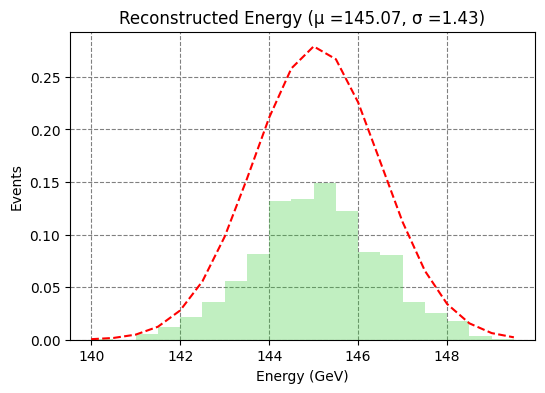

In [94]:
#plot histogram + gaussian fit
ax = df_he.plot('n_hits', 
        kind='hist', 
        bins=custom_bins,
        density=False,
        weights = bin_weights,
        title = 'Reconstructed Energy (μ ='+str(np.round(mu,2))+', σ ='+str(np.round(std,2))+')',
        ylabel = 'Events', 
        xlabel='Energy (GeV)',
        rot = 0,
        color='limegreen',
        legend = None,
        figsize=(6, 4),
        alpha=0.3)


ax.plot(custom_bins, p, color='red', linestyle='dashed')
ax.set_axisbelow(True)
ax.yaxis.grid(color='gray', linestyle='dashed')
ax.xaxis.grid(color='gray', linestyle='dashed')
ax.get_figure().savefig('energy-distribution-'+root_file+'.png', bbox_inches = 'tight')